In [1]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from hamitonian import hamitonian_para
from qannealing import annealing
from data_score import Generate_Data, score
import numpy as np

In [12]:
n = 2
m = 1
delta_max = 20
delta_cons = 20
delta_trans = 20

D = Generate_Data(n)
C, h, J = hamitonian_para(n, m, D, delta_max, \
                           delta_cons, delta_trans)
print(h)
print(J)

[26.0513574  81.89773248  0.         10.         20.         10.
 20.        ]
[[ 0.   0.   2.5  0.   0.   5.  10. ]
 [ 0.   0.  -2.5  5.  10.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  10.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  10. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]]


In [15]:
M = 100
T = 1
lamda = 1

circ = annealing(n, M, h, J, T, lamda)
simulator = AerSimulator()
compiled_circuit = transpile(circ, simulator)
job = simulator.run(compiled_circuit, shots = 1000)
res = job.result()
counts = res.get_counts(compiled_circuit)
ans = max(counts)
print(ans)

1111111


In [72]:
# circ.draw('mpl')

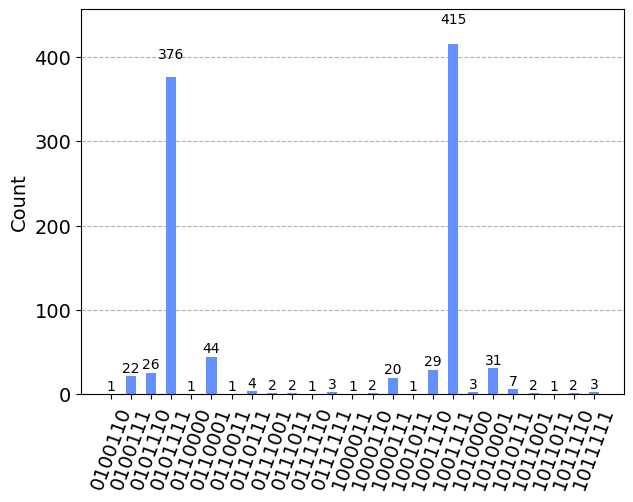

In [80]:
from qiskit.visualization import array_to_latex, plot_histogram
plot_histogram(counts)

In [30]:

# As a simple example:
n = 2
m = 1

#  leagal results
G = np.array([[0, 0],
              [1, 0]])
print(score(G, D, n))
G = np.array([[0, 1],
              [0, 0]]) # which is 'correct' with minimal score
print(score(G, D, n))
G = np.array([[0, 1],
              [1, 0]])
print(score(G, D, n))

# unlegal ones:
print('-----')
G = np.array([[1, 0],
              [1, 0]])
print(score(G, D, n))
G = np.array([[1, 1],
              [1, 0]])
print(score(G, D, n))
G = np.array([[1, 0],
              [0, 1]])
print(score(G, D, n))

188.76175393146065
189.9932673738719
181.39765742861982
-----
68.17876069069072
60.81466418784988
17.22818423431721
